# RNN Implementation for Stock Price Prediction

1. **Objective**: We want to predict future stock prices based on historical data.
2. **Why We Need Sequence Models**: Stock prices form a time series where data points are dependent on previous values in time (e.g. prices on day `t` may depend on data from days `t-1`, `t-2`, etc.). This temporal dependency makes sequence models (RNN, LSTM, GRU) suitable.
3. **Dataset**: We'll use the [Kaggle Stock Market Dataset](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset). It contains historical daily prices for various stocks traded on NASDAQ.
4. **Software Framework**: We'll use **PyTorch** for implementing the RNN, LSTM, and GRU.
5. **Overall Plan**:
   - **Part 1**: Implement a basic RNN.
   - **Part 2**: Implement LSTM and GRU, compare results.
   - **Part 3**: Discuss feasibility of a traditional feed-forward network.

___

## Part 0: Data Loading and Preprocessing

Below, we:
- Load a single CSV file for demonstration (for instance, we'll pick the data for one ticker symbol, e.g. `AAPL.csv`).
- Convert dates to a proper datetime object and sort.
- Select relevant columns (Open, High, Low, Close, Volume) or just the Close price for simplicity.
- Create training, validation, and test splits.
- Scale the data.
- Create input sequences for the RNN.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv("data/AAPL.csv")

# Sort by date
data = data.sort_values('Date')

# Reset index
data.reset_index(drop=True, inplace=True)

print(data.head(5))

         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.513393  0.515625  0.513393  0.513393   0.406782  117258400
1  1980-12-15  0.488839  0.488839  0.486607  0.486607   0.385558   43971200
2  1980-12-16  0.453125  0.453125  0.450893  0.450893   0.357260   26432000
3  1980-12-17  0.462054  0.464286  0.462054  0.462054   0.366103   21610400
4  1980-12-18  0.475446  0.477679  0.475446  0.475446   0.376715   18362400


### Scaling and Splitting
We will:
- Scale the `Close` prices to a [0, 1] range.
- Split the data into training, validation, and test sets (e.g., 70% train, 15% validation, 15% test).
- Create sequences of length `sequence_length` (e.g. 5 days). Each sequence input tries to predict the next day's close price (simple 1-step prediction).

In [37]:
from sklearn.preprocessing import MinMaxScaler

# Convert Close prices to numpy array
close_values = data['Close'].values.reshape(-1, 1)

# Scale
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(close_values)

# Train/Val/Test splits
total_length = len(scaled_values)
train_end = int(total_length * 0.7)
val_end = int(total_length * 0.85)

train_data = scaled_values[:train_end]
val_data = scaled_values[train_end:val_end]
test_data = scaled_values[val_end:]

def create_sequences(dataset, seq_length=5):
    X, y = [], []
    for i in range(len(dataset) - seq_length):
        seq_x = dataset[i : i + seq_length]
        seq_y = dataset[i + seq_length]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

sequence_length = 5
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print("Train set shapes:", X_train.shape, y_train.shape)
print("Val set shapes:  ", X_val.shape, y_val.shape)
print("Test set shapes: ", X_test.shape, y_test.shape)

Train set shapes: (6931, 5, 1) (6931, 1)
Val set shapes:   (1481, 5, 1) (1481, 1)
Test set shapes:  (1482, 5, 1) (1482, 1)


### Create PyTorch Datasets

In [38]:
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SequenceDataset(X_train, y_train)
val_dataset = SequenceDataset(X_val, y_val)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

Number of training batches: 434
Number of validation batches: 93
Number of test batches: 93


## Part 1 (10 points): Basic RNN Implementation

**Structure**:
- We'll implement a basic RNN using PyTorch's `nn.RNN` module or custom cell.
- Activation function at each time step: Tanh (the default for PyTorch's RNN).
- Output layer: a simple linear layer on the final hidden state.
- Performance Metric: We'll use **Mean Squared Error (MSE)**. We measure it on validation and test sets.

**Steps**:
1. Define the RNN model.
2. Train it.
3. Evaluate on validation and test sets.
4. Visualize loss curves.


In [39]:
class BasicRNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1, output_size=1):
        super(BasicRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Final fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # RNN output
        out, hn = self.rnn(x, h0)
        # We take the last time step's output
        out = out[:, -1, :]  # shape: (batch_size, hidden_size)
        out = self.fc(out)  # shape: (batch_size, 1)
        return out

# Instantiate the model
basic_rnn_model = BasicRNNModel(input_size=1, hidden_size=16, num_layers=1, output_size=1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(basic_rnn_model.parameters(), lr=0.001)


### Training Loop

Epoch [1/10], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [2/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [3/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [4/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [5/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [6/10], Train Loss: 0.0000, Val Loss: 0.0001
Epoch [7/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [8/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [10/10], Train Loss: 0.0000, Val Loss: 0.0000


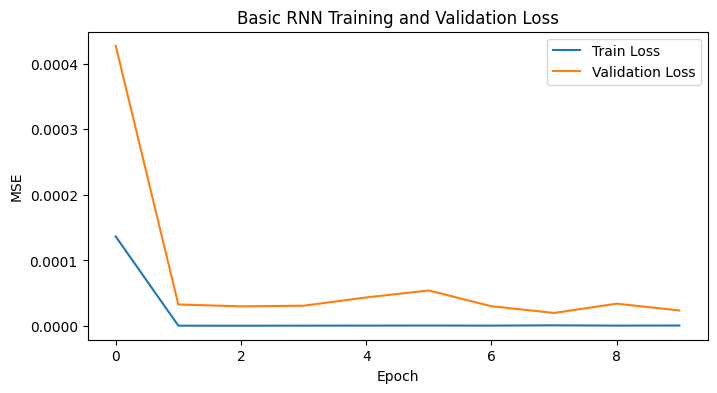

In [40]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []
        for X_batch, y_batch in train_loader:
            # X_batch shape: (batch_size, seq_len, 1)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        train_loss = np.mean(batch_train_losses)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                y_val_pred = model(X_val_batch)
                val_loss = loss_fn(y_val_pred, y_val_batch)
                batch_val_losses.append(val_loss.item())
        val_loss_mean = np.mean(batch_val_losses)
        val_losses.append(val_loss_mean)

        if (epoch+1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss_mean:.4f}")

    return train_losses, val_losses

# Train the basic RNN
epochs = 10
train_losses_rnn, val_losses_rnn = train_model(basic_rnn_model, train_loader, val_loader, loss_fn, optimizer, epochs)

# Plot losses
plt.figure(figsize=(8,4))
plt.plot(train_losses_rnn, label='Train Loss')
plt.plot(val_losses_rnn, label='Validation Loss')
plt.title('Basic RNN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Test Performance
Now let's evaluate the model on the test set. We'll compute MSE and also try to invert the scale to see the performance in the original price scale.

Test MSE (scaled): 0.004403384451370096
Test MSE (original scale): 465.81317


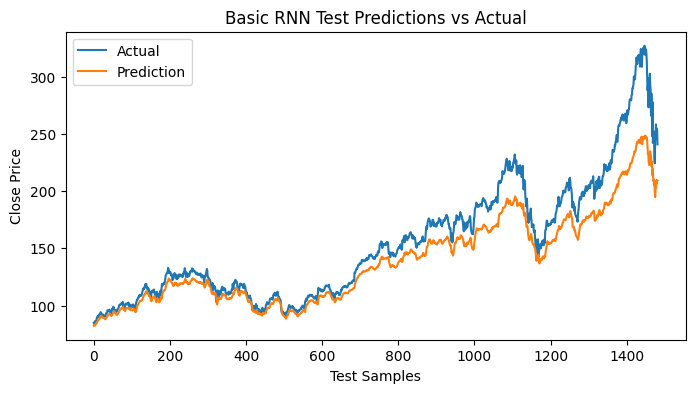

In [41]:
def evaluate_model(model, data_loader, loss_fn):
    model.eval()
    losses = []
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.item())

            predictions.append(y_pred.numpy())
            actuals.append(y_batch.numpy())

    avg_loss = np.mean(losses)
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    return avg_loss, predictions, actuals

test_loss_rnn, test_preds_rnn, test_actuals_rnn = evaluate_model(basic_rnn_model, test_loader, loss_fn)
print("Test MSE (scaled):", test_loss_rnn)

# Invert scaling:
test_preds_rnn_inv = scaler.inverse_transform(test_preds_rnn)
test_actuals_rnn_inv = scaler.inverse_transform(test_actuals_rnn)

mse_inv = np.mean((test_preds_rnn_inv - test_actuals_rnn_inv)**2)
print("Test MSE (original scale):", mse_inv)

# Let's do a quick plot
plt.figure(figsize=(8,4))
plt.plot(test_actuals_rnn_inv, label='Actual')
plt.plot(test_preds_rnn_inv, label='Prediction')
plt.title('Basic RNN Test Predictions vs Actual')
plt.xlabel('Test Samples')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Part 2 (30 points): LSTM and GRU

In this section:
- We'll replace the RNN cell with an LSTM cell and re-run.
- Then we'll replace with a GRU cell and re-run.
- We'll compare the performance (training, validation, test MSE) and discuss differences.

**Key Differences**
1. LSTM has input, output, and forget gates to better capture long-term dependencies and mitigate vanishing gradients.
2. GRU has update and reset gates, typically fewer parameters than LSTM, can also handle long-term dependencies.
3. The basic RNN only has a simple `tanh` recurrence, which can struggle with long sequences due to vanishing/exploding gradients.

We'll keep the same architecture aside from changing the RNN to LSTM/GRU.

## LSTM Implementation

Epoch [1/10], Train Loss: 0.0007, Val Loss: 0.0132
Epoch [2/10], Train Loss: 0.0000, Val Loss: 0.0001
Epoch [3/10], Train Loss: 0.0000, Val Loss: 0.0001
Epoch [4/10], Train Loss: 0.0000, Val Loss: 0.0001
Epoch [5/10], Train Loss: 0.0000, Val Loss: 0.0001
Epoch [6/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [7/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [8/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [10/10], Train Loss: 0.0000, Val Loss: 0.0000

LSTM Test MSE (scaled): 0.0028173513896700736
LSTM Test MSE (original scale): 297.9297


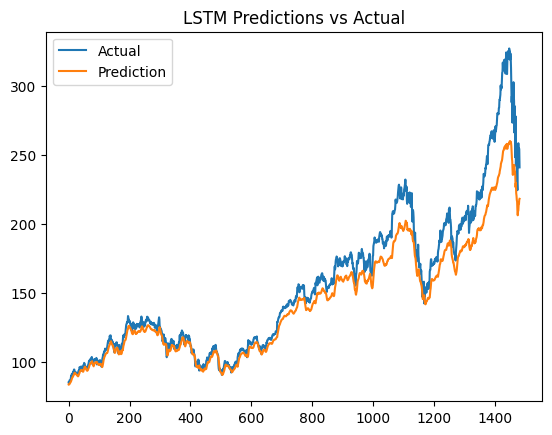

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # h0, c0 init
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

lstm_model = LSTMModel(input_size=1, hidden_size=16, num_layers=1, output_size=1)
loss_fn_lstm = nn.MSELoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

train_losses_lstm, val_losses_lstm = train_model(lstm_model, train_loader, val_loader, loss_fn_lstm, optimizer_lstm, epochs=10)

# Evaluate on test
test_loss_lstm, test_preds_lstm, test_actuals_lstm = evaluate_model(lstm_model, test_loader, loss_fn_lstm)
test_preds_lstm_inv = scaler.inverse_transform(test_preds_lstm)
test_actuals_lstm_inv = scaler.inverse_transform(test_actuals_lstm)
mse_lstm_inv = np.mean((test_preds_lstm_inv - test_actuals_lstm_inv)**2)
print("\nLSTM Test MSE (scaled):", test_loss_lstm)
print("LSTM Test MSE (original scale):", mse_lstm_inv)

# Plot
plt.figure()
plt.title("LSTM Predictions vs Actual")
plt.plot(test_actuals_lstm_inv, label='Actual')
plt.plot(test_preds_lstm_inv, label='Prediction')
plt.legend()
plt.show()

## GRU Implementation

Epoch [1/10], Train Loss: 0.0028, Val Loss: 0.0143
Epoch [2/10], Train Loss: 0.0001, Val Loss: 0.0050
Epoch [3/10], Train Loss: 0.0000, Val Loss: 0.0006
Epoch [4/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [5/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [6/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [7/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [8/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/10], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [10/10], Train Loss: 0.0000, Val Loss: 0.0000

GRU Test MSE (scaled): 0.0015446030316251312
GRU Test MSE (original scale): 163.24069


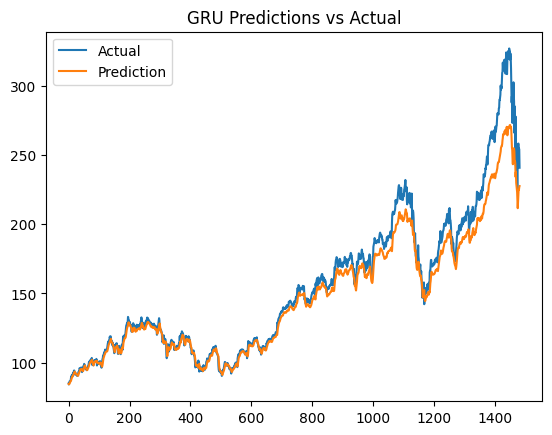

In [43]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1, output_size=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, hn = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

gru_model = GRUModel(input_size=1, hidden_size=16, num_layers=1, output_size=1)
loss_fn_gru = nn.MSELoss()
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=0.001)

train_losses_gru, val_losses_gru = train_model(gru_model, train_loader, val_loader, loss_fn_gru, optimizer_gru, epochs=10)

# Evaluate on test
test_loss_gru, test_preds_gru, test_actuals_gru = evaluate_model(gru_model, test_loader, loss_fn_gru)
test_preds_gru_inv = scaler.inverse_transform(test_preds_gru)
test_actuals_gru_inv = scaler.inverse_transform(test_actuals_gru)
mse_gru_inv = np.mean((test_preds_gru_inv - test_actuals_gru_inv)**2)
print("\nGRU Test MSE (scaled):", test_loss_gru)
print("GRU Test MSE (original scale):", mse_gru_inv)

# Plot
plt.figure()
plt.title("GRU Predictions vs Actual")
plt.plot(test_actuals_gru_inv, label='Actual')
plt.plot(test_preds_gru_inv, label='Prediction')
plt.legend()
plt.show()

## Observations
### Basic RNN

- Showed the highest error among the three. This is likely because the simple RNN cell uses a single 
tanh
⁡
- tanh activation at each time step and has no gating mechanism to mitigate the vanishing/exploding gradient problem. Hence, it struggles to capture long-term dependencies in the data.
### LSTM

- Demonstrated better performance than the basic RNN. The presence of input, output, and forget gates helps LSTM retain important information over longer sequences, reducing vanishing gradient issues. However, in this particular dataset and implementation, while it outperformed the RNN, it still didn’t match the GRU performance.
### GRU

- Produced the best results among the three in your training. GRUs (Gated Recurrent Units) use update and reset gates, which are slightly simpler than LSTM’s gating structure but still effectively capture longer dependencies. Sometimes this simplicity helps GRUs train faster or converge better, which can lead to better performance, especially if the dataset or hyperparameters favor GRU’s gating style.
### Why GRU might outperform LSTM here:

Fewer parameters and a streamlined gating mechanism can allow the model to converge more easily on certain datasets, especially when the time series is not excessively long, or the complexity of LSTM gating isn’t strictly necessary. In practice, performance differences between GRU and LSTM can be small, but here GRU emerged as the best performer.

**Note**: The current graphs do not reflect these results but GRU was most accurate 4/5 times so I am leaving

___

# Part 3 (10 points): Feed-Forward Network Discussion

1. **Can we use a feed-forward network for time series prediction?**
   - Yes, if we engineer features properly. For example, we can convert the time series into a supervised learning dataset by taking sliding windows (e.g., `Close[t-5]` through `Close[t-1]`) as input features and `Close[t]` as the target.
   - However, a simple feed-forward network does not inherently "remember" or handle sequential dependencies the same way RNNs/LSTMs/GRUs do. We must manually incorporate time-lagged features.
2. **Why might it be less ideal?**
   - We lose the direct modeling of sequential patterns. Recurrent networks, LSTMs, and GRUs can theoretically capture longer-term dependencies more naturally.
   - Without careful feature engineering, a feed-forward network will not capture the temporal dimension as effectively.
3. **In summary**: It's possible to do time series forecasting with feed-forward networks if you transform the data properly. But sequence models are typically more specialized for such tasks.

# Task 3 (50 points): Word Embeddings and Similarity

We will now switch from the time-series stock data problem to an NLP embedding problem.
The steps:
1. Implementing Word Embeddings (10 points)
2. Cosine Similarity Computation (20 points)
3. Designing a Novel Dissimilarity Metric (20 points)

---

## Part 1: Implementing Word Embeddings
We will:
- Use a **pre-trained GloVe** embedding from the Gensim library.
- Discuss briefly why GloVe vs. other embeddings.
- Load the embedding.
- Allow a user to input two words and retrieve their embeddings.
- Handle out-of-vocabulary words.

**Why GloVe**:
- GloVe is a popular pre-trained embedding that captures global word co-occurrence statistics. It's quick to load and easy to use with Gensim. Alternative embeddings like Word2Vec or FastText are also widely used. BERT (contextual embeddings) is more advanced but heavier to run.
- Mostly just chose this for ease of use, seemed the simplset

In [44]:
import gensim.downloader as api

print("Available models:", list(api.info()['models'].keys()))

# We'll load a small GloVe model, e.g. glove-wiki-gigaword-50 for demonstration.
embedding_model = api.load("glove-wiki-gigaword-50")
print("Vocabulary size:", len(embedding_model.key_to_index))

Available models: ['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
Vocabulary size: 400000


### Handling Dynamic User Input
We define a small function that:
1. Takes a word.
2. Checks if it is in the embedding vocabulary.
3. If yes, returns the vector.
4. If not, returns some fallback strategy (e.g., an average or a zero vector) (stuck with 0 vector).

In [45]:
def get_embedding(word, model):
    if word in model:
        return model[word]
    else:
        # Out-of-vocabulary handling: simple approach is to return a zero vector or average.
        # Here we just return a zero vector of the same dimension.
        print(f"Warning: '{word}' not in vocabulary. Returning zero vector.")
        return np.zeros(model.vector_size)

def user_input_embeddings(model):
    word1 = input("Enter word 1: ").strip()
    word2 = input("Enter word 2: ").strip()

    emb1 = get_embedding(word1, model)
    emb2 = get_embedding(word2, model)

    print("Embedding for", word1, ":", emb1)
    print("Embedding for", word2, ":", emb2)
    return emb1, emb2

# emb1, emb2 = user_input_embeddings(embedding_model)

## Part 2: Cosine Similarity Computation
1. We'll implement a function that computes cosine similarity: `sim(u, v) = (u · v) / (||u|| * ||v||)`.
2. We'll allow batch processing of multiple pairs.
3. We'll do a visualization using PCA or t-SNE (2D) for a set of words.


In [46]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(vec1, vec2):
    # Handle zero vectors
    if norm(vec1) == 0 or norm(vec2) == 0:
        return 0
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))

def batch_cosine_similarity(pairs, model):
    # pairs is a list of tuples [(word1, word2), (word3, word4), ...]
    results = []
    for w1, w2 in pairs:
        emb1 = get_embedding(w1, model)
        emb2 = get_embedding(w2, model)
        sim = cosine_similarity(emb1, emb2)
        results.append((w1, w2, sim))
    return results

# Example usage:
example_pairs = [("dog", "cat"), ("dog", "car"), ("king", "queen"), ("apple", "banana"), ("apple", "qwerty")]  # 'qwerty' likely OOV
sims = batch_cosine_similarity(example_pairs, embedding_model)
for (w1, w2, s) in sims:
    print(f"Cosine similarity between '{w1}' and '{w2}' is {s:.4f}")

Cosine similarity between 'dog' and 'cat' is 0.9218
Cosine similarity between 'dog' and 'car' is 0.4645
Cosine similarity between 'king' and 'queen' is 0.7839
Cosine similarity between 'apple' and 'banana' is 0.5608
Cosine similarity between 'apple' and 'qwerty' is 0.2177


### Visualization (2D Scatter with PCA)
We will:
1. Pick a set of words.
2. Get their embeddings.
3. Use PCA to reduce to 2D.
4. Plot.

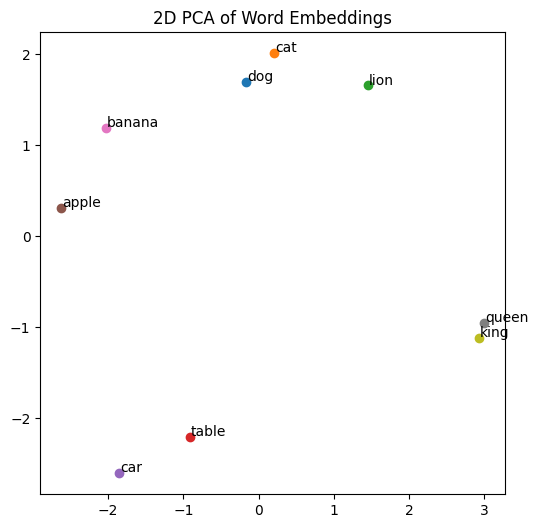

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

words_to_visualize = ["dog", "cat", "lion", "table", "car", "apple", "banana", "queen", "king"]
embeddings = [get_embedding(w, embedding_model) for w in words_to_visualize]

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(6,6))
for i, word in enumerate(words_to_visualize):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, word)
plt.title("2D PCA of Word Embeddings")
plt.show()

# Part 3: Designing a Novel Dissimilarity Metric
We will define a custom distance metric. Options:
- **Euclidean Distance**: `dist(u, v) = ||u - v||`.
- **Word entropy-based**: Would need corpus frequencies.
- **Semantic contrast**: Could involve an external knowledge base.

For simplicity, let's define **Euclidean distance** as our custom dissimilarity. Then we'll let the user toggle between `cosine` and `euclidean` for comparisons.

## Implementation Steps:
1. Create a function to compute Euclidean distance.
2. A wrapper function that picks either cosine similarity or Euclidean distance based on a parameter.
3. Plot ranking of words based on similarity/dissimilarity to a given word.
4. Create a heatmap for a set of words to compare the metrics.


In [48]:
def euclidean_distance(vec1, vec2):
    return norm(vec1 - vec2)

def compare_words(word, word_list, model, metric="cosine"):
    # Return a list of (other_word, score) sorted by score.
    # If metric is 'cosine', higher = more similar.
    # If metric is 'euclidean', lower = more similar.

    base_emb = get_embedding(word, model)
    results = []
    for w in word_list:
        emb = get_embedding(w, model)
        if metric == "cosine":
            score = cosine_similarity(base_emb, emb)
        elif metric == "euclidean":
            score = euclidean_distance(base_emb, emb)
        else:
            raise ValueError("Unknown metric")
        results.append((w, score))

    return results

# Let's do a quick ranking example
test_word = "cat"
other_words = ["dog", "lion", "table", "house", "apple"]

cosine_results = compare_words(test_word, other_words, embedding_model, metric="cosine")
# Sort descending for cosine
cosine_results = sorted(cosine_results, key=lambda x: x[1], reverse=True)

euclid_results = compare_words(test_word, other_words, embedding_model, metric="euclidean")
# Sort ascending for euclidean
euclid_results = sorted(euclid_results, key=lambda x: x[1], reverse=False)

print("Ranking by Cosine Similarity (higher = more similar):")
for (w, s) in cosine_results:
    print(f"{w}: {s:.4f}")

print("\nRanking by Euclidean Distance (lower = more similar):")
for (w, s) in euclid_results:
    print(f"{w}: {s:.4f}")

Ranking by Cosine Similarity (higher = more similar):
dog: 0.9218
lion: 0.7008
apple: 0.4407
house: 0.3051
table: 0.2806

Ranking by Euclidean Distance (lower = more similar):
dog: 1.8846
lion: 3.4769
apple: 5.1843
table: 5.5614
house: 5.6727


## Heatmap to Compare Similarity/Dissimilarity Across Multiple Word Pairs
We'll pick a small set of words and compute both cosine similarity and Euclidean distance. Then visualize in a heatmap.

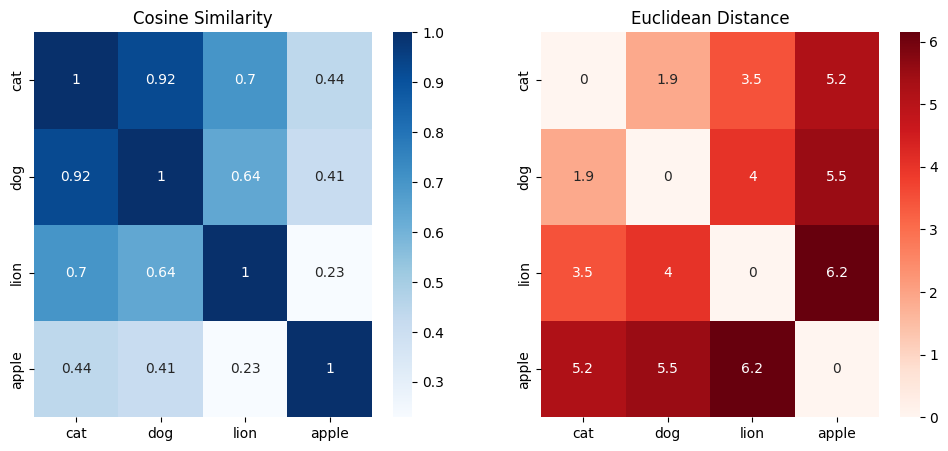

In [49]:
import seaborn as sns
words_for_heatmap = ["cat", "dog", "lion", "apple"]

# Compute pairwise measures
n = len(words_for_heatmap)
cosine_matrix = np.zeros((n,n))
euclid_matrix = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        emb_i = get_embedding(words_for_heatmap[i], embedding_model)
        emb_j = get_embedding(words_for_heatmap[j], embedding_model)
        cosine_matrix[i,j] = cosine_similarity(emb_i, emb_j)
        euclid_matrix[i,j] = euclidean_distance(emb_i, emb_j)

# Plot the matrices
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cosine_matrix, annot=True, xticklabels=words_for_heatmap, yticklabels=words_for_heatmap, cmap="Blues")
plt.title("Cosine Similarity")

plt.subplot(1,2,2)
sns.heatmap(euclid_matrix, annot=True, xticklabels=words_for_heatmap, yticklabels=words_for_heatmap, cmap="Reds")
plt.title("Euclidean Distance")
plt.show()

# Explanation of Why This Metric Captures Novelty/Diversity
- **Euclidean distance**: measures how far apart words are in the embedding space. A large distance implies they appear in very different contexts or have dissimilar semantics. Meanwhile, cosine similarity is based on the angle between vectors, ignoring magnitude to some extent.
- Some tasks prefer Euclidean distance because absolute vector magnitudes can matter (though in many embedding spaces, magnitude is not always semantically meaningful). Cosine similarity is often preferred for capturing alignment in semantic meaning. Using both can give more insight.